<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/20.00.Aula-Cenario_Rio.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- O cenário de múltiplos do Pop350: parâmetros](19.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_parametros.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelo individual: incluindo a fase de exposição ->](21.00.Aula-Modelo_individual_infeccao_e_recuperacao.ipynb)

---


# O cenário da cidade do Rio de Janeiro: rede de empresas

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 08/Jun/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- posicionamos as residências;

- distribuímos os indivíduos em suas residências; e 

- posicionamos os indivíduos em torno de suas residências.

### Carregando os dados

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../input/dados_rio/landscan_rio.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

### Visualização em escala logarítmica

Visualizamos 

$$ ln( 1 + \textrm{população})
$$

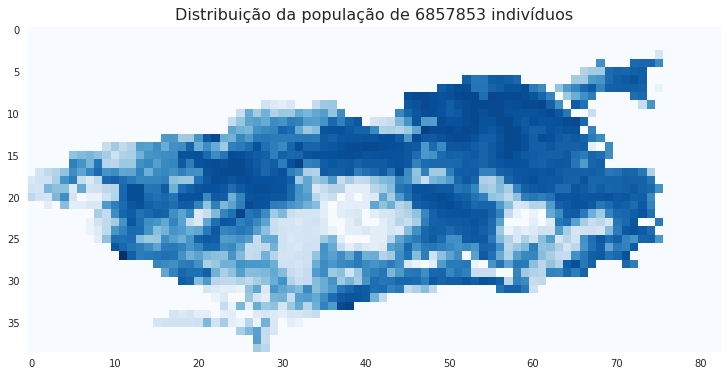

In [6]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + landscan_rio), cmap='Blues', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [7]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
pop_por_blocos = (landscan_rio/100).astype(int)

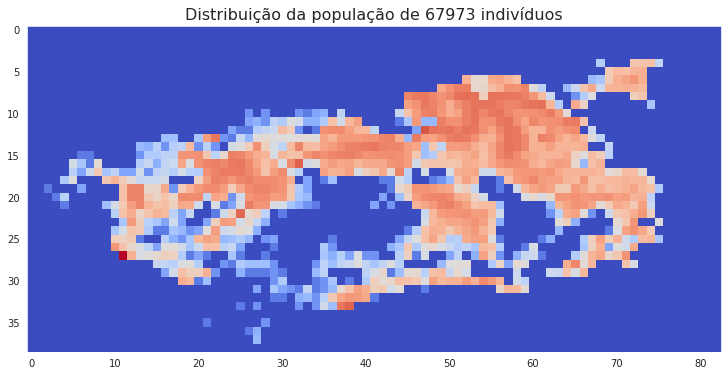

In [8]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + pop_por_blocos), cmap='coolwarm', interpolation='none')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_blocos.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuindo e alocando os indivíduos e as suas residências

In [9]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_blocos, censo_residencial)

CPU times: user 473 ms, sys: 0 ns, total: 473 ms
Wall time: 472 ms


In [10]:
pop_blocos_indices[-1]

67973

### Gerando o grafo da rede residencial

In [11]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_blocos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 217 ms, sys: 7.53 ms, total: 225 ms
Wall time: 226 ms


### Viualização

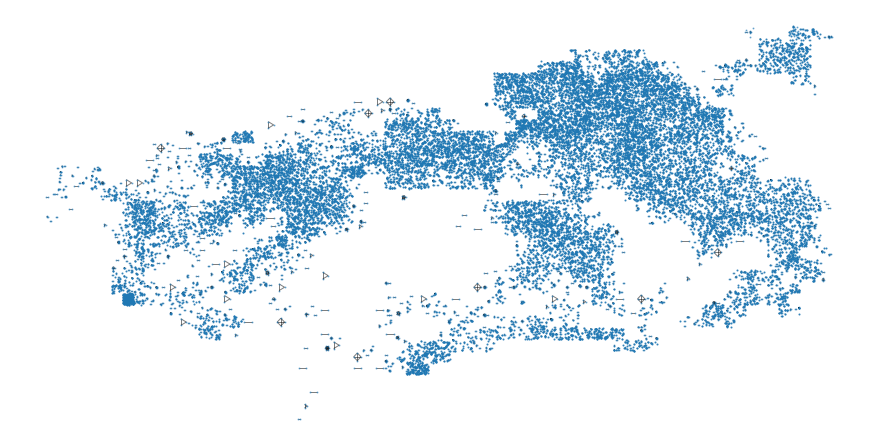

CPU times: user 958 ms, sys: 203 ms, total: 1.16 s
Wall time: 874 ms


In [12]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Rede empresarial

Na construção da rede empresarial, a ideia é fazer os seguintes passos:

- Distribuir o número de empresas por tamanho da empresa seguindo uma distribuição na forma de uma lei de potência próxima a de uma [lei de Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law), com parâmetros escolhidos de acordo com a população total e um número máximo de tamanho (ou médio?).

- Distribuir as empresas pelos blocos, com pesos de acordo com a população de cada bloco.

- Alocar os indivíduos em cada empresa, levando em consideração uma determinada distância média de deslocamento.

In [13]:
estabelecimentos_rio = np.load('../input/dados_rio/estabelecimentos.npy').astype(int)

In [14]:
print(f'Total de estabelecimentos: {estabelecimentos_rio.sum()}')

Total de estabelecimentos: 263


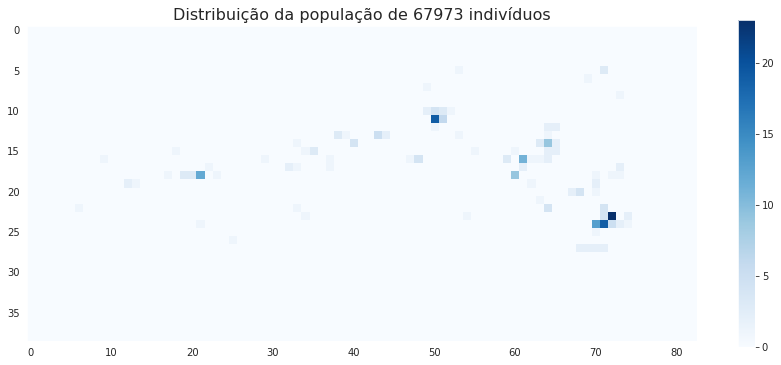

In [15]:
plt.figure(figsize=(15,6))
plt.imshow(estabelecimentos_rio, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_blocos.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuição das empresas por tamanho

Da página do IBGE com o [Cadastro Central de Empresas](https://cidades.ibge.gov.br/brasil/rj/rio-de-janeiro/pesquisa/19/0?indicador=29761), temos os seguintes dados globais para a cidade do Rio de Janeiro:

| Número de indivíduos ocupados | Número de empresas | Média de indivíduos por empresa |
| --- | --- | --- |
| 2.566.694 | 195.110 | 13,15 |

A página menciona, ainda, o número de indivíduos assalariados (2.269.964) e o número de "unidades locais" (209.237). Uma pesquisa melhor é necessária para esclarecer os dados e, ainda, para ver se conseguimos detalhes sobre a distribuição espacial das empresas.

#### Distribuição log-normal

Distribuição [log-normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)

In [16]:
emp_tam_medio = 10
shape = 1
scale = np.exp(emp_tam_medio) 
loc = 0

emp_tams = np.arange(1,1001)
emp_nind = stats.lognorm.pdf(emp_tams, shape, loc, scale)

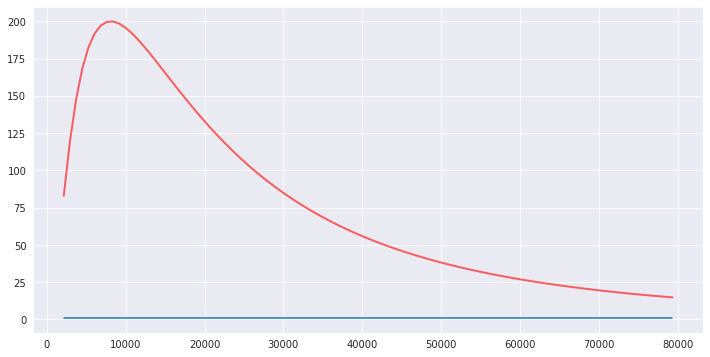

In [17]:
x = np.linspace(stats.lognorm.ppf(0.01, shape, loc, scale),
                stats.lognorm.ppf(0.9, shape, loc, scale), 100)

plt.figure(figsize=(12,6))
plt.plot(x, 6700000*stats.lognorm.pdf(x, shape, loc, scale),
       'r-', lw=2, alpha=0.6, label='lognorm pdf')
plt.plot(x, np.ones_like(x))
plt.show()




#### Lei de potência do tipo Zipf com três parâmetros

- Aqui a lei de potência que eles usam para a distribuição da densidade de trabalhadores por tamanho do local de trabalho:

$$ \mathcal{P}(n > k) = f_3(k; a, c, k_\textrm{max}) 
= \frac{\displaystyle \left(\frac{\displaystyle 1 + \frac{k_\textrm{max}}{a}}{\displaystyle 1 + \frac{k}{a}}\right)^c - 1}{\displaystyle \left( 1 + \frac{k}{a}\right)^c -1}, \qquad 0 \leq k \leq k_\textrm{max}
$$

- Para a Tailândia, os parâmetros são $a = 3.26$, $c=0.97$ e $k_\textrm{max} = 2870$.

- Para os EUA e para a Grã-Bretanha, os parâmetros são $a = 5.36$, $c=1.34$ e $l_\textrm{max} = 5920$.

- Para o Rio de Janeiro ...

In [18]:
num_pop = pop_por_blocos.sum()
num_pop *= 1
print(num_pop)

67973


In [19]:
censo_fracoes = [0.15079769082144653,  # 0 a 9 anos
                 0.17906470565542282,  # 10 a 19 anos
                 0.18007108135150324,  # 20 a 29 anos
                 0.15534569934620965,  # 30 a 39 anos
                 0.13023309451263393,  # 40 a 49 anos
                 0.09654553673621215,  # 50 a 59 anos
                 0.059499784853198616, # 60 a 69 anos
                 0.033053176013799715, # 70 a 79 anos
                 0.015389230709573343  # 80 ou mais
                ]

In [20]:
num_pop_20a69 = int(num_pop*sum(censo_fracoes[2:7])) # consideramos apenas 20 a 69 anos 
print(f'População em idade ativa: {num_pop_20a69}')

População em idade ativa: 42258


In [21]:
num_pop_emp = int(0.8*num_pop_20a69)
print(f'População economicamente ativa: {num_pop_emp}')

População economicamente ativa: 33806


## População economicamente ativa

### Frações da população economicamente ativa por idade

In [22]:
pea_idades_grupos = np.array([0, 16, 18, 23, 50, 70, 100])
pea_idades_fracoes_grupos = np.array([0, 0.2, 0.75, 0.85, 0.75, 0.15, 0])

In [23]:
pea_idades_fracoes = list()
for j in range(len(pea_idades_grupos)-1):
    pea_idades_fracoes += (pea_idades_grupos[j+1] - pea_idades_grupos[j]) \
        * [pea_idades_fracoes_grupos[j]]

#pea_idades_fracoes = np.array(pea_idades_fracoes)*idades_fracoes
pea_idades_fracoes = np.array(pea_idades_fracoes)
print(f'Fração da população economicamente ativa: {pea_idades_fracoes.sum():.1f} %')

Fração da população economicamente ativa: 46.6 %


### Conserte o resto em vista das duas últimas células obtendo a Pop. Econ. Ativ a partir das idades sorteadas.

In [24]:
emp_max = 1000
print(f'Tamanho máximo de empresa: {emp_max}')

Tamanho máximo de empresa: 1000


In [25]:
def zipf3(a, c, k_max, k):
    '''
    retorna a fração de indivíduos em empresas de tamanho maior que k.
    '''
    return (((1.0 + k_max/a)/(1.0 + k/a))**c - 1)/((1 + k_max/a)**c - 1.0)

def zipf3_sec(a, c, k_max, k0, k1):
    '''
    retorna a fração de individuos em empresas de tamanho maior ou igual a k0 e menor que k1.
    '''
    return zipf3(a, c, k_max, k0) - zipf3(a, c, k_max, k1)

def zipf3e(a, c, k_max, k):
    '''
    retorna a fração de empresas de tamanho k.
    '''
    return zipf3_sec(a, c, k_max, k-1, k)/k

In [26]:
z3_a = 5.1
z3_c = 0.9
z3_max = emp_max

In [27]:
print(zipf3(z3_a, z3_c, z3_max, 0))
print(zipf3(z3_a, z3_c, z3_max, 1))
print(zipf3_sec(z3_a, z3_c, z3_max, 0, 1))
print(zipf3e(z3_a, z3_c, z3_max, 1))

1.0
0.8498779775590548
0.1501220224409452
0.1501220224409452


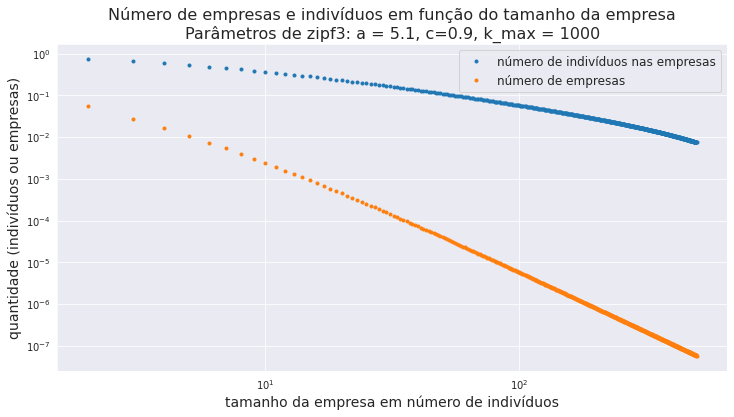

In [28]:
tam_min = 2
tam_max = int(z3_max/2)
tam_z3 = np.array(range(tam_min, tam_max+1))
pop_z3 = zipf3(z3_a, z3_c, z3_max, tam_z3)
emp_z3 = zipf3e(z3_a, z3_c, z3_max, tam_z3)
plt.figure(figsize=(12,6))
plt.plot(tam_z3, pop_z3, 'o', ms=3, label='número de indivíduos nas empresas')
plt.plot(tam_z3, emp_z3, 'o', ms=3, label='número de empresas')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('tamanho da empresa em número de indivíduos', fontsize=14)
plt.ylabel('quantidade (indivíduos ou empresas)', fontsize=14)
plt.title('Número de empresas e indivíduos em função do tamanho da empresa\n'
          + f'Parâmetros de zipf3: a = {z3_a}, c={z3_c}, k_max = {z3_max}', fontsize=16)
plt.show()

In [29]:
def quantifica_empresas_por_tamanho(num_pop, num_pop_emp, tam_min, z3_a, z3_c, z3_max, verbose=False):

    emp_tams_z3 = np.arange(tam_min, z3_max)
    emps_num_z3 = (num_pop_emp*zipf3e(z3_a, z3_c, z3_max, emp_tams_z3)).astype(int)
    emps_num_z3 = emps_num_z3[emps_num_z3>0]
    emp_tams_z3 = np.array(list(range(tam_min, tam_min + len(emps_num_z3))))
    emps_pop_z3 = np.array([(tam_min + k)*emps_num_z3[k] for k in range(len(emps_num_z3))])

    if not len(emp_tams_z3):
        print('Não foi possível distribuir as empresas, tente com outros parâmetros')
    elif verbose:
        print(f'Total da população: {num_pop}')
        print(f'Total da força de trabalho: {num_pop_emp}')
        print(f'Número de tamanhos de empresas: {len(emps_num_z3)}')
        print(f'Número de empresas: {emps_num_z3.sum()}')
        print(f'Tamanhos de empresas: de {emp_tams_z3.min()} a {emp_tams_z3.max()}')
        print(f'Número de indivíduos nas empresas: {emps_pop_z3.sum()}')
        print(f'Média de indivíduos por empresa: {emps_pop_z3.sum()/emps_num_z3.sum()}')
        print('Porcentagem de indivíduos da força de trabalho nas empresas: '
              + f'{100*emps_pop_z3.sum()/num_pop_emp:.1f}%')
        print(f'Distribuição de empresas por tamanho: \n{emps_num_z3}')
        print(f'Distribuição de indivíduos por tamanho de empresa: \n{emps_pop_z3}')
    
    return emp_tams_z3, emps_num_z3, emps_pop_z3

In [30]:
emp_tams_z3, emps_num_z3, emps_pop_z3 = \
    quantifica_empresas_por_tamanho(num_pop, num_pop_emp, tam_min, z3_a, z3_c, z3_max,
                                   verbose=True)

Total da população: 67973
Total da força de trabalho: 33806
Número de tamanhos de empresas: 54
Número de empresas: 4922
Tamanhos de empresas: de 2 a 55
Número de indivíduos nas empresas: 24663
Média de indivíduos por empresa: 5.010767980495733
Porcentagem de indivíduos da força de trabalho nas empresas: 73.0%
Distribuição de empresas por tamanho: 
[1853  943  559  362  250  180  135  103   81   65   53   44   36   31
   26   22   19   17   15   13   11   10    9    8    7    6    6    5
    5    4    4    4    3    3    3    3    2    2    2    2    2    2
    1    1    1    1    1    1    1    1    1    1    1    1]
Distribuição de indivíduos por tamanho de empresa: 
[3706 2829 2236 1810 1500 1260 1080  927  810  715  636  572  504  465
  416  374  342  323  300  273  242  230  216  200  182  162  168  145
  150  124  128  132  102  105  108  111   76   78   80   82   84   86
   44   45   46   47   48   49   50   51   52   53   54   55]


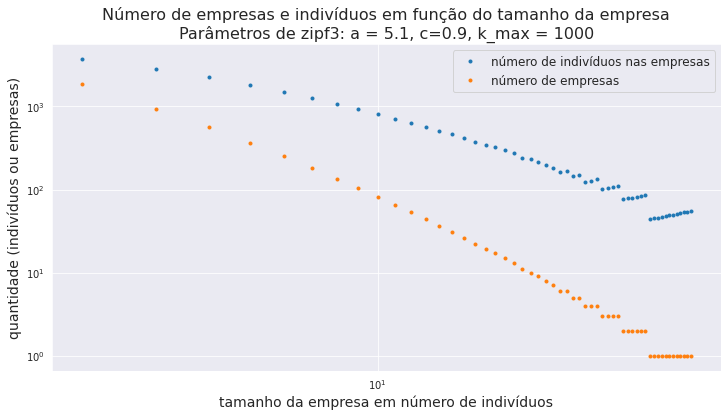

In [31]:
plt.figure(figsize=(12,6))
plt.plot(emp_tams_z3, emps_pop_z3, 'o', ms=3, label='número de indivíduos nas empresas')
plt.plot(emp_tams_z3, emps_num_z3, 'o', ms=3, label='número de empresas')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('tamanho da empresa em número de indivíduos', fontsize=14)
plt.ylabel('quantidade (indivíduos ou empresas)', fontsize=14)
plt.title('Número de empresas e indivíduos em função do tamanho da empresa\n'
          + f'Parâmetros de zipf3: a = {z3_a}, c={z3_c}, k_max = {z3_max}', fontsize=16)
plt.show()

In [32]:
wsc = [0, 6, 11, 21, 51, 101]
nwsc = []
for j in range(1,len(wsc)):
    nwsc.append(emps_pop_z3[wsc[j-1]:wsc[j]].sum())
nwsc.append(emps_pop_z3[wsc[j]:].sum())

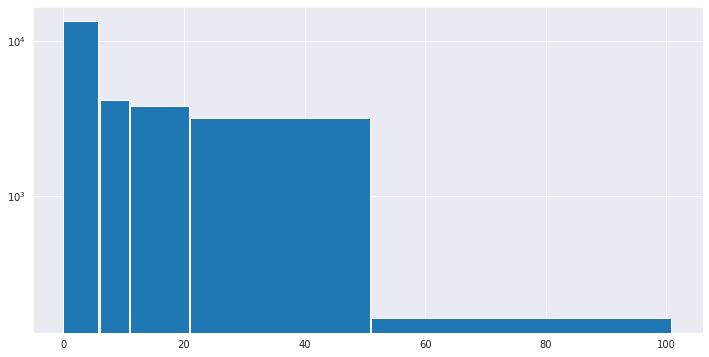

In [33]:
bar_width = [wsc[j] - wsc[j-1] - 0.2 for j in range(1,len(wsc))]
bar_width.append(emp_tams_z3[-1]-wsc[-1])
plt.figure(figsize=(12,6))
plt.bar(wsc, nwsc, bar_width, align='edge')
plt.yscale('log')
plt.show()

In [34]:
%%time
random.seed(1207)
pop_blocos_flat = pop_por_blocos.flatten()
emp_loc = random.choices(list(range(len(pop_blocos_flat))), pop_blocos_flat/num_pop, k=emps_num_z3.sum())

CPU times: user 4.49 ms, sys: 0 ns, total: 4.49 ms
Wall time: 4.46 ms


In [35]:
emp_por_blocos = np.zeros_like(pop_por_blocos)
emp_bloco_pos = list()
emp_tam = list()
k_nivel = 0
for k in range(len(emp_loc)):
    if k >= emps_num_z3[:k_nivel+1].sum():
        k_nivel += 1
    emp_tam.append(tam_min + k_nivel)
    loc = emp_loc[k]
    emp_bloco_pos.append((loc // 83, loc % 83))
    emp_por_blocos[loc // 83, loc % 83] += 1
print(f'Número de indivíduos alocados: {sum(emp_tam)}')

Número de indivíduos alocados: 24663


In [36]:
print(f'Total de empresas alocadas: {emp_por_blocos.sum()}')
print(f'Maior concentração de empresas: {emp_por_blocos.max()}')

Total de empresas alocadas: 4922
Maior concentração de empresas: 39


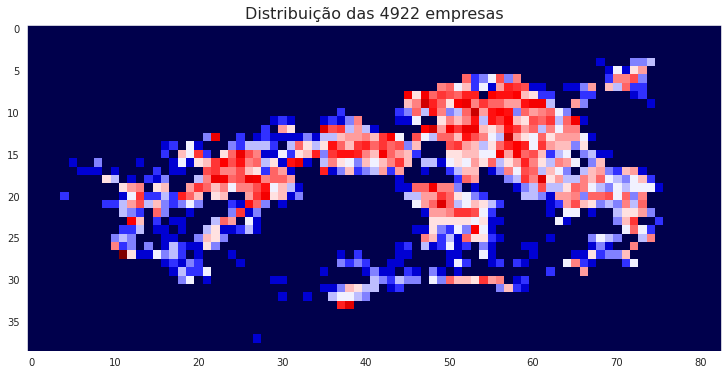

In [37]:
plt.figure(figsize=(15,6))
plt.imshow(np.log(1 + emp_por_blocos), cmap='seismic', interpolation='nearest')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_blocos.sum()} empresas', fontsize=16)
plt.show()

### Localização das empresas

Neste primeiro momento, não vou me preocupar com isso.

Vamos considerar a localização das empresas como sendo o centro do bloco em que cada empresa está.

Posteriormente podemos localizá-las aleatoriamente dentro dos blocos, como feito na rede residencial.

### Distribuição da população economicamente ativa nas empresas

- Agora, para cada empresa, vamos alocar indivíduos de acordo com a distância até ela.

- Vamos assumir que temos uma variável com o deslocamento médio dos indivíduos até o trabalho, digamos `emp_desloc_medio_geral`.

- Vamos variar um pouco, essa distância média, seguindo uma distribuição gaussiana em torno dela.

- Posteriormente, podemos variar proporcionalmente ao tamanho da empresa, com empresas maiores exibindo um deslocamento médio maior:

    - $g(k/k_\text{medio})$ distância média de uma empresa de tamanho $k$.
    
    - $g$ crescente
    
    - $(1/N)\sum_k n(k)g(k/k_\text{medio}) = 1$




### Moovit

A reportagem [Moradores do RJ são os que gastam mais tempo em transporte público entre 10 regiões metropolitanas do país](https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/01/15/moradores-do-rj-sao-os-que-gastam-mais-tempo-em-transporte-publico-entre-10-regioes-metropolitanas-do-brasil-mostra-aplicativo.ghtml) menciona uma média de 67 min por viagem, na região metropolitana do Rio de Janeiro. 

O que é mais interessante é a menção ao fato dos dados terem sido obtidos pelo Moovit. Isso significa que os seus dados devem ser, sim, significativos.

Devemos lembrar que, além da distância média, é interessante ajustarmos os dados de deslocamento a alguma distribuição de probabilidades.

É mencionado, pelo menos, que 36% levam entre 1 e 2 horas para chegar ao destino e 11% levam mais de 2 horas.

#### 

O artigo https://www.anpec.org.br/encontro/2014/submissao/files_I/i10-1dc14346dd67760748fefecaac00a05a.pdf dá bem mais detalhes, inclusive por bairros da cidade, baseado na análise do CENSO de 2010.

Veja, também, https://m.sebrae.com.br/Sebrae/Portal%20Sebrae/UFs/RJ/Menu%20Institucional/SEBRAE_EPG_set13_mob_urb_merc_trab_rj.pdf


#### Variação do deslocamento médio

In [38]:
emp_desloc_medio_geral = 10
emp_desloc_sigma_geral = 0.4

emp_desloc_medio = np.random.lognormal(mean=np.log(emp_desloc_medio_geral),
                                       sigma=emp_desloc_sigma_geral,
                                       size=emps_num_z3.sum())
emp_desloc_medio = np.minimum(emp_desloc_medio, 70)
emp_desloc_medio.mean()

10.993414927098236

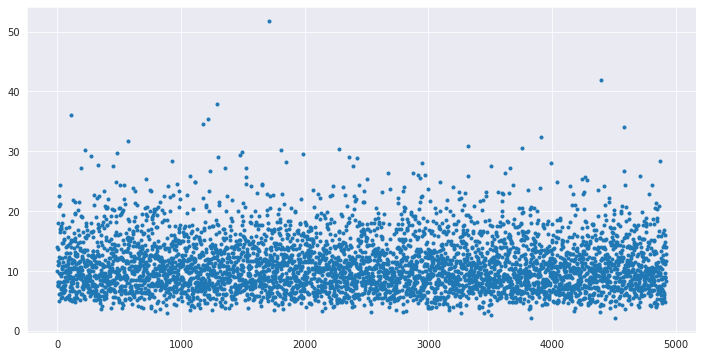

In [39]:
plt.figure(figsize=(12,6))
plt.plot(emp_desloc_medio, '.')
plt.show()

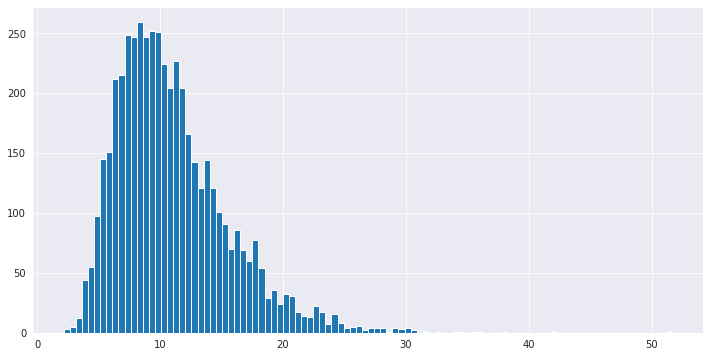

In [40]:
plt.figure(figsize=(12,6))
plt.hist(emp_desloc_medio, 100)
plt.show()

### Distribuição por bloco

In [41]:
i = np.arange(emp_por_blocos.shape[0])
j = np.arange(emp_por_blocos.shape[1])
jj, ii = np.meshgrid(j,i)
dist =  np.sqrt((jj - 25)**2 + (ii - 15)**2)
f_dist = 1/(1 + dist**0.5)
print(f_dist.min())

0.11312230461094948


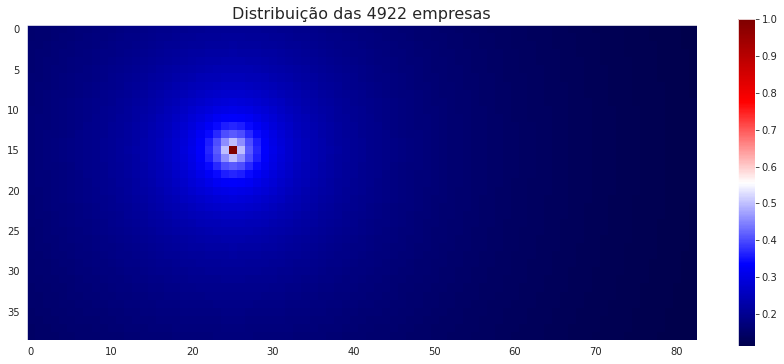

In [42]:
plt.figure(figsize=(15,6))
plt.imshow(f_dist, cmap='seismic', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_blocos.sum()} empresas', fontsize=16)
plt.show()

In [43]:
k_dist = f_dist * pop_por_blocos / num_pop
k_dist /= k_dist.sum()

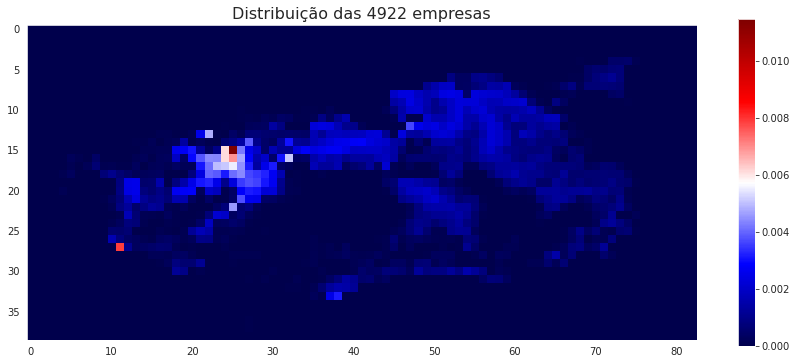

In [44]:
plt.figure(figsize=(15,6))
plt.imshow(k_dist, cmap='seismic', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_blocos.sum()} empresas', fontsize=16)
plt.show()

In [45]:
%%time
random.seed(2321)
emp_ind = list()

dens_blocos = pop_por_blocos / num_pop

for k in range(len(emps_num_z3)):
    for j in range(emps_num_z3[k]):
        dist =  np.sqrt((jj - emp_bloco_pos[k+j][1])**2 + (emp_bloco_pos[k+j][0] - 8)**2)
        k_dist = 1/(1 + dist)
        k_dist *= dens_blocos
        k_dist /= k_dist.sum()
        emp_ind.append(
            random.choices(list(range(emp_por_blocos.shape[0]*emp_por_blocos.shape[1])),
                           k_dist.flatten(),
                           k = tam_min + k)
        )
              
print(f'Número de blocos alocados: {sum([len(emp_ind[k]) for k in range(len(emp_ind))])}')   

Número de blocos alocados: 24663
CPU times: user 3.03 s, sys: 14.3 ms, total: 3.04 s
Wall time: 3.05 s


In [46]:
print(len(emp_bloco_pos)) # bloco em que cada empresa está localizada
print(len(emp_tam)) # tamanho de cada empresa
print(len(emp_ind)) # localização linear do bloco dos indivíduos de cada empresa

4922
4922
4922


In [47]:
tst = np.array([1,2,3,4,5])
%timeit np.intersect1d(tst[tst > 2], tst[tst < 5], assume_unique=True)

7.62 µs ± 252 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [48]:
pop_indices = np.array(list(range(num_pop)))
#random.sample(pop_indices[])
j = 200
emp_ind[j][0]

print(pop_blocos_indices[emp_ind[j][0]])
print(pop_blocos_indices[emp_ind[j][0]+1])

%timeit pop_indices[pop_indices >= pop_blocos_indices[emp_ind[j][0]]]

%timeit candidatos= np.intersect1d(pop_indices[pop_indices >= pop_blocos_indices[emp_ind[j][0]]],pop_indices[pop_indices < pop_blocos_indices[emp_ind[j][0]+1]], assume_unique=True)

aux = pop_indices[pop_indices >= pop_blocos_indices[emp_ind[j][0]]]
candidatos = aux[aux < pop_blocos_indices[emp_ind[j][0]+1]]


%timeit pop_indices[pop_indices >= pop_blocos_indices[emp_ind[j][0]]]
%timeit aux[aux < pop_blocos_indices[emp_ind[j][0]+1]]

print(candidatos)
#np.setdiff1d

%timeit random.choice(candidatos)

#pop_indices[pop_indices < pop_blocos_indices[emp_ind[j][0]+1]]
#pop_indices[pop_blocos_indices[emp_ind[j][0]] <= pop_indices < pop_blocos_indices[emp_ind[j][0]+1]]

21475
21617
70.8 µs ± 451 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
817 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
69.8 µs ± 768 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
22.5 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
[21475 21476 21477 21478 21479 21480 21481 21482 21483 21484 21485 21486
 21487 21488 21489 21490 21491 21492 21493 21494 21495 21496 21497 21498
 21499 21500 21501 21502 21503 21504 21505 21506 21507 21508 21509 21510
 21511 21512 21513 21514 21515 21516 21517 21518 21519 21520 21521 21522
 21523 21524 21525 21526 21527 21528 21529 21530 21531 21532 21533 21534
 21535 21536 21537 21538 21539 21540 21541 21542 21543 21544 21545 21546
 21547 21548 21549 21550 21551 21552 21553 21554 21555 21556 21557 21558
 21559 21560 21561 21562 21563 21564 21565 21566 21567 21568 21569 21570
 21571 21572 21573 21574 21575 21576 21577 21578 21579 21580 21581 21582
 21583 21584 21585 21586 21587 21588 21

In [49]:
%timeit np.where(aux == 42732)
%timeit np.delete(aux, np.where(aux == 42732))
%timeit aux[aux!=42732]

21.5 µs ± 306 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
90.4 µs ± 3.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
62.2 µs ± 1.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [50]:
%%time
pop_indices = np.array(range(num_pop))
emp_membros = dict()

for j in range(len(emp_tam)):
    membros_j = list()
    for l in emp_ind[j]:
        aux = pop_indices[pop_indices >= pop_blocos_indices[l]]
        candidatos = aux[aux < pop_blocos_indices[l+1]]
        if len(candidatos):
            individuo = random.choice(candidatos)
#            print(j, individuo)
            membros_j.append(individuo)
#            print(membros_j)
            pop_indices = pop_indices[pop_indices != individuo]
    emp_membros.update({j: membros_j})

CPU times: user 3.76 s, sys: 6.44 ms, total: 3.76 s
Wall time: 3.77 s


In [51]:
emp_membros
len(pop_blocos_indices)
pop_blocos_indices[l]
num_pop
emp_ind[j]
pop_blocos_flat[l]

133

In [52]:
m = 0
for j in range(len(emp_tam)):
    if len(emp_membros[j]) < emp_tam[j]:
#        print(f'Empresa {j} com {emp_tam[j] - len(emp_membros[j])} vagas não preenchidas')
        m += emp_tam[j] - len(emp_membros[j])
    elif len(emp_membros[j]) > emp_tam[j]:
        print(f'Ops em j={j}')
print(f'Total de {m} empresas com vagas não preenchidas')

Total de 2277 empresas com vagas não preenchidas


In [53]:
for j in range(len(emp_tam)):
    faltam = emp_tam[j] - len(emp_membros[j])
    if faltam > 0:
        membros_j = random.choices(pop_indices, k=faltam)
#        print(membros_j)
        emp_membros[j] += membros_j
        if emp_tam[j] - len(emp_membros[j]) > 0:
            print(f'Não completou em j={j}')
            print(emp_tam[j])
            print(len(emp_membros[j]))
            print(faltam)
            print(membros_j)
            print(len(emp_membros[j]))
            print()
        pop_indices = pop_indices[pop_indices != individuo]

In [54]:
aux = emp_membros[10].copy()
aux_m = membros_j[:1]
aux += aux_m
emp_membros[10]

[57184, 2798]

In [55]:
print(f'População em idade ativa: {num_pop}')
print(f'Número de pessoas alocadas: {sum([len(emp) for emp in emp_membros.values()])}')
print(f'População não alocada: {num_pop - sum([len(emp) for emp in emp_membros.values()])}')
print(f'Número de vagas: ')

População em idade ativa: 67973
Número de pessoas alocadas: 24663
População não alocada: 43310
Número de vagas: 


<!--NAVIGATOR-->

---
[<- O cenário de múltiplos do Pop350: parâmetros](19.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_parametros.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelo individual: incluindo a fase de exposição ->](21.00.Aula-Modelo_individual_infeccao_e_recuperacao.ipynb)